# Running spike sorting on Neuropixel probe data

In [1]:
# need library to save as json
import os
import re
import subprocess
from pathlib import Path
import numpy as np
from kilosort.io import save_probe
from kilosort.parameters import DEFAULT_SETTINGS
from kilosort.run_kilosort import run_kilosort
import SGLXMetaToCoords as sglx

### Sorting data from 24-05-31

Files directory: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0
Meta file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap.meta
Binary file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap.bin
Data directory: D:\SortingTemp
Run name: 24-05-31_DH23_A1-IC
Gate number: 0
Trigger number: 0
Probe number: 0


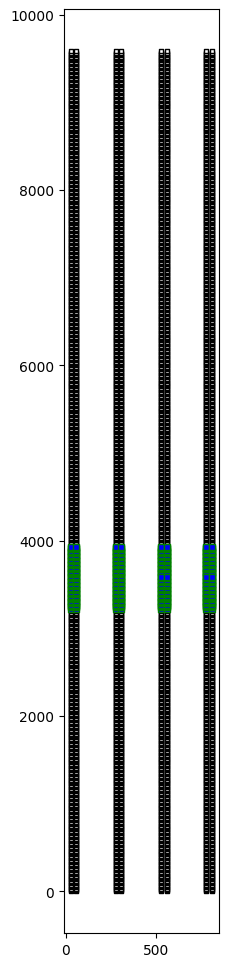

Saving probe file to: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\probe.json
Running CatGT...

Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  73.80s; total  73.86s

computing drift
Re-computing universal templates from data.


c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 13507/13507 [2:26:06<00:00,  1.54it/s]  


drift computed in  9411.45s; total  9485.34s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 13507/13507 [2:28:53<00:00,  1.51it/s]  


36410702 spikes extracted in  9011.34s; total  18496.78s

First clustering


100%|██████████| 24/24 [1:20:59<00:00, 202.49s/it]


1301 clusters found, in  4874.39s; total  23371.17s

Extracting spikes using cluster waveforms


100%|██████████| 13507/13507 [1:45:19<00:00,  2.14it/s]


58358271 spikes extracted in  6346.31s; total  29717.48s

Final clustering


100%|██████████| 24/24 [9:02:53<00:00, 1357.23s/it]   


819 clusters found, in  32573.84s; total  62291.46s

Merging clusters
736 units found, in  161.53s; total  62452.99s

Saving to phy and computing refractory periods
272 units found with good refractory periods

Total runtime: 62952.72s = 17:29:13 h:m:s


In [3]:
# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0")

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 8} # threshold for detecting spikes used in learned templates

# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if skip_catgt and Path(tcat_file).exists():
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)

Files directory: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1
Meta file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.ap.meta
Binary file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.ap.bin
Data directory: D:\SortingTemp
Run name: 24-05-31_DH23_A1-IC
Gate number: 0
Trigger number: 0
Probe number: 1


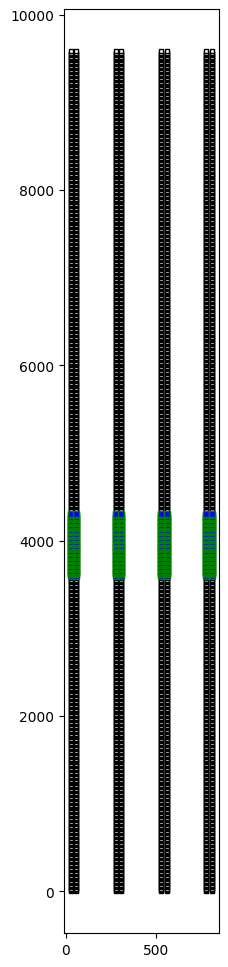

Saving probe file to: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\probe.json
CatGT already ran, skipping...
Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  68.50s; total  68.55s

computing drift
Re-computing universal templates from data.


c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 13507/13507 [2:27:03<00:00,  1.53it/s]   


drift computed in  9448.79s; total  9517.38s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 13507/13507 [2:25:31<00:00,  1.55it/s]   


37611279 spikes extracted in  8802.05s; total  18319.53s

First clustering


100%|██████████| 24/24 [1:20:18<00:00, 200.76s/it]


1310 clusters found, in  4831.48s; total  23151.01s

Extracting spikes using cluster waveforms


100%|██████████| 13507/13507 [1:38:39<00:00,  2.28it/s]  


49513574 spikes extracted in  5963.53s; total  29114.54s

Final clustering


100%|██████████| 24/24 [2:02:28<00:00, 306.17s/it]  


910 clusters found, in  7348.44s; total  36463.15s

Merging clusters
688 units found, in  134.82s; total  36597.97s

Saving to phy and computing refractory periods
324 units found with good refractory periods

Total runtime: 37044.25s = 10:17:24 h:m:s


In [2]:
# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec1")

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 9} # threshold for detecting spikes used in learned templates

# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if skip_catgt and Path(tcat_file).exists():
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)

### Sorting data from 24-06-03

Files directory: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec0
Meta file: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec0\24-06-03_DH23_LEC-LL_g0_t0.imec0.ap.meta
Binary file: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec0\24-06-03_DH23_LEC-LL_g0_t0.imec0.ap.bin
Data directory: D:\SortingTemp
Run name: 24-06-03_DH23_LEC-LL
Gate number: 0
Trigger number: 0
Probe number: 0


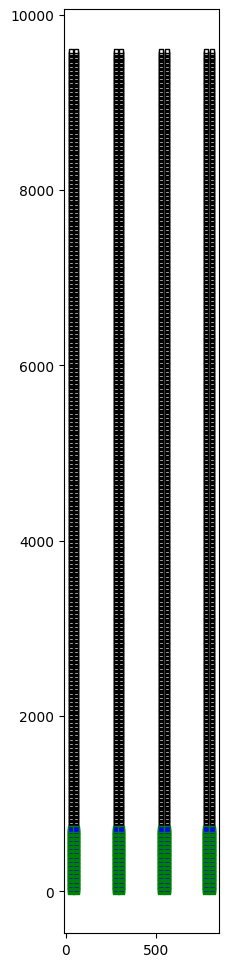

Saving probe file to: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec0\probe.json
CatGT already ran, skipping...
Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  56.16s; total  56.22s

computing drift
Re-computing universal templates from data.


c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 9761/9761 [1:45:04<00:00,  1.55it/s]  


drift computed in  6698.80s; total  6755.07s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 9761/9761 [1:41:51<00:00,  1.60it/s]  


20402374 spikes extracted in  6177.33s; total  12932.49s

First clustering


100%|██████████| 24/24 [20:47<00:00, 51.99s/it] 


1406 clusters found, in  1265.29s; total  14197.78s

Extracting spikes using cluster waveforms


100%|██████████| 9761/9761 [1:02:52<00:00,  2.59it/s]


27504164 spikes extracted in  3782.22s; total  17980.00s

Final clustering


100%|██████████| 24/24 [38:17<00:00, 95.74s/it] 


743 clusters found, in  2298.05s; total  20278.11s

Merging clusters
692 units found, in  99.45s; total  20377.56s

Saving to phy and computing refractory periods
308 units found with good refractory periods

Total runtime: 20621.21s = 05:43:41 h:m:s


In [3]:
# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path("D:\\SortingTemp\\24-06-03_DH23_LEC-LL_g0\\24-06-03_DH23_LEC-LL_g0_imec0")

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 8} # threshold for detecting spikes used in learned templates

# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if Path(tcat_file).exists():
    bin_size = Path(bin_file).stat().st_size
    tcat_size = Path(tcat_file).stat().st_size
    tcat_exists = bin_size == tcat_size
    
if skip_catgt and tcat_exists:
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)

Files directory: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec1
Meta file: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec1\24-06-03_DH23_LEC-LL_g0_t0.imec1.ap.meta
Binary file: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec1\24-06-03_DH23_LEC-LL_g0_t0.imec1.ap.bin
Data directory: D:\SortingTemp
Run name: 24-06-03_DH23_LEC-LL
Gate number: 0
Trigger number: 0
Probe number: 1


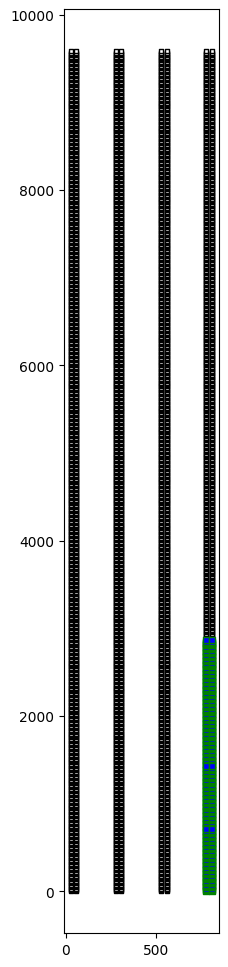

Saving probe file to: D:\SortingTemp\24-06-03_DH23_LEC-LL_g0\24-06-03_DH23_LEC-LL_g0_imec1\probe.json
CatGT already ran, skipping...
Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  49.01s; total  49.05s

computing drift
Re-computing universal templates from data.


c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 9762/9762 [1:13:34<00:00,  2.21it/s]


drift computed in  4896.34s; total  4945.42s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 9762/9762 [1:12:36<00:00,  2.24it/s]


28141941 spikes extracted in  4407.11s; total  9352.56s

First clustering


100%|██████████| 96/96 [1:40:14<00:00, 62.66s/it]   


967 clusters found, in  6022.61s; total  15375.17s

Extracting spikes using cluster waveforms


100%|██████████| 9762/9762 [1:03:29<00:00,  2.56it/s]


38275626 spikes extracted in  3824.96s; total  19200.15s

Final clustering


 25%|██▌       | 24/96 [17:46<1:06:59, 55.83s/it]

In [2]:
# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path("D:\\SortingTemp\\24-06-03_DH23_LEC-LL_g0\\24-06-03_DH23_LEC-LL_g0_imec1")

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 10} # threshold for detecting spikes used in learned templates

# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if Path(tcat_file).exists():
    bin_size = Path(bin_file).stat().st_size
    tcat_size = Path(tcat_file).stat().st_size
    tcat_exists = bin_size == tcat_size
else:
    tcat_exists = False

if skip_catgt and tcat_exists:
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)